In [ ]:
!pip -q install optuna opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
import os, cv2, gc
import warnings
import random
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.random import set_seed
from typing import Any, Tuple, Dict, List, Union
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

warnings.filterwarnings(action="ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/MyDrive/hyperparameter analysis"

In [ ]:
# Set random seed to ensure code is reproducible
SEED = 42

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    set_seed(seed)
    os.environ['PYTHONHASHSEED']=str(SEED)

set_random_seed(SEED)

## Load the dataset

In [ ]:
# Load dataset
DATASET = "cifar10"
(X_train, y_train), (X_val, y_val) = getattr(datasets, DATASET).load_data()
X_train.shape, X_val.shape

170498071/170498071 [==============================] - 6s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
print(y_train.shape, y_val.shape)

(50000, 1) (10000, 1)


## Visualise Data Samples

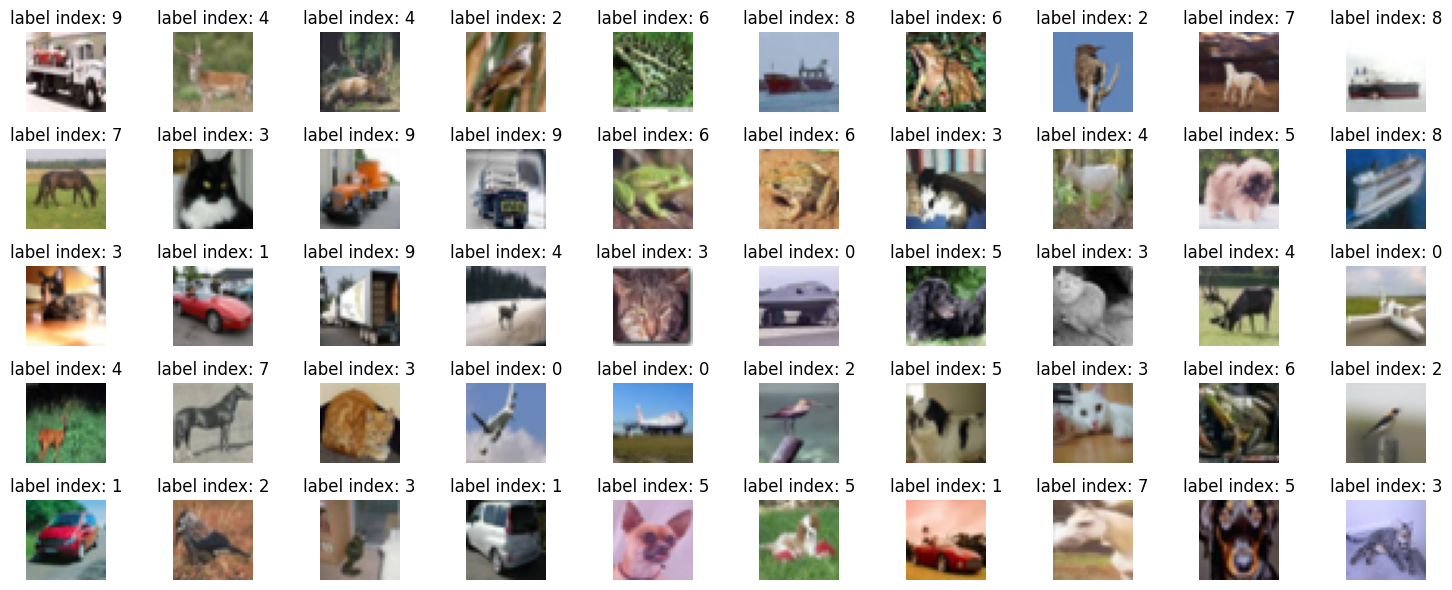

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(15, 6))

indexes = random.sample(range(len(X_train)), 50)
axes = axes.flatten()
for index, ax in zip(indexes, axes):
  ax.set_title(f"label index: {y_train[index][0]}")
  ax.imshow(X_train[index])
  ax.set_axis_off()

fig.tight_layout()
plt.savefig(f'{DATASET} sample images.png')
plt.show()

### Scale Data from range (0 - 255) to range (0 - 1)

In [ ]:
X_train, X_val = X_train / 255.0, X_val / 255.0

## Define Utility Functions

In [ ]:
def build_model(base_model: Model, num_classes: int, dropout_rate: float) -> Sequential:
    """
    Build neural network model.

    Args:
        base_model (Model): Pre-trained base model to build upon.
        num_classes (int): Number of output classes.
        dropout_rate (float): Dropout rate to apply after the Flatten layer.

    Returns:
        Sequential: A new sequential model with added layers.
    """

    # Create a new sequential model
    model = Sequential()

    # Add the pre-trained base model
    model.add(base_model)

    # Add a Flatten layer to convert output of base model to 1D array
    model.add(Flatten())

    # Add a Dropout layer to help prevent overfitting
    model.add(Dropout(dropout_rate))

    # Add a Dense layer with softmax activation for classification
    model.add(Dense(num_classes, activation="softmax"))

    return model

In [ ]:
def get_predictions(model: Model, X: np.ndarray) -> np.ndarray:
    """
    Get model predictions and corresponding labels.

    Args:
        model (Model): Trained neural network model.
        X (np.ndarray): Input data for prediction.

    Returns:
        tuple:
            - np.ndarray: Predicted probabilities for each class.
            - np.ndarray: Predicted labels (class indices) for each sample.
    """

    # Get predicted probabilities for each class
    proba = model.predict(X)

    # Get predicted labels by selecting the class index with highest probability
    labels = np.argmax(proba, axis=-1)

    return proba, labels

In [2]:
def compute_f1_precision_recall_auc(
    y_true: np.ndarray,
    pred_proba: np.ndarray,
    y_pred: np.ndarray) -> Tuple[float, float, float, float]:
    """
    Compute F1 score, precision, recall, and AUC-ROC for predicted data.

    Args:
        y_true (np.ndarray): Ground truth labels.
        pred_proba (np.ndarray): Predicted probabilities for each class.
        y_pred (np.ndarray): Predicted labels.

    Returns:
        tuple:
            - float: Macro-averaged F1 score.
            - float: precision
            - float: recall
            - float: Area under the ROC curve (AUC-ROC).
    """

    # Compute F1 score using macro-averaging
    f1 = f1_score(y_true, y_pred, average="macro")

    # Compute precision using macro-averaging
    precision = precision_score(y_true, y_pred, average="macro")

    # Compute recall using macro-averaging
    recall = recall_score(y_true, y_pred, average="macro")

    # Compute AUC-ROC using One-vs-Rest (OvR) strategy
    auc = roc_auc_score(y_true, pred_proba, multi_class="ovr")

    return f1, precision, recall, auc

## Create and Instantiate CollectorQueue Class and Object

In [ ]:
class CollectorQueue:
    """
    A queue-like structure to collect and manage experiment information, metrics, and histories.

    Attributes:
        trial (List[int]): List to store experiment indices.
        metrics (List[Dict[str, float]]): List to store metric dictionaries.
        histories (List[Dict[str, Any]]): List to store history dictionaries.
    """

    def __init__(self):
        self.trial: List[int] = []
        self.metrics: List[Dict[str, float]] = []
        self.histories: List[Dict[str, Any]] = []

    def enqueue(self, trial_idx: int, metrics: Dict[str, float], history: Dict[str, Any]):
        """Add experiment information, metrics, and history to the collector."""
        self.trial.append(trial_idx)
        self.metrics.append(metrics)
        self.histories.append(history)

    def clear(self):
        """Clear all stored trial information, metrics, and histories."""
        self.trial = []
        self.metrics = []
        self.histories = []
        return self


In [ ]:
queue = CollectorQueue()

## Define Objective Function for Hyper-parameter Searching

In [ ]:
def objective_func(
    trial: optuna.trial.Trial,
    base_model: Model,
    num_classes: int,
    hyperparameter_space_dict: Dict[str, Any],
    dataset_dict: Dict[str, np.ndarray],
    metric_weights: Dict[str, float],
    ) -> float:

    """
    Objective function for hyperparameter optimization using Optuna.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        base_model (Model):  base model.
        num_classes (int): Number of output classes.
        hyperparameter_space_dict (Dict[str, Any]): Dictionary of hyperparameter spaces.
        dataset_dict (Dict[str, np.ndarray]): Dictionary containing dataset arrays.
        metric_weights (Dict[str, float]): Weights for different metrics.

    Returns:
        float: Weighted sum of metrics as the optimization objective.
    """
    clear_session()

    # Check if metric weights sum to 1.0
    if sum(metric_weights.values()) != 1.0:
        raise ValueError("sum of values of metric_weights must equate to 1.0")

    # Hyperparameter space suggestions
    dropout_rate = trial.suggest_float("dropout_rate", **hyperparameter_space_dict["dropout_rate"])
    optimizer = trial.suggest_categorical("optimizer", hyperparameter_space_dict["optimizer"])
    learning_rate = trial.suggest_float("learning_rate", **hyperparameter_space_dict["learning_rate"])
    batch_size = trial.suggest_int("batch_size", **hyperparameter_space_dict["batch_size"])
    epochs = trial.suggest_int("epochs", **hyperparameter_space_dict["epochs"])

    # Build model
    model = build_model(base_model, num_classes, dropout_rate=dropout_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss=SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )

    # Train model
    model_history = model.fit(
        dataset_dict["X_train"],
        dataset_dict["y_train"],
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(dataset_dict["X_val"], dataset_dict["y_val"]),
        verbose=0,
    )

    # Compute validation metrics
    val_pred_proba, val_pred_labels = get_predictions(model, X_val)
    val_accuracy = max(model_history.history["val_accuracy"])
    val_f1, val_precision, val_recall, val_auc = compute_f1_precision_recall_auc(
        y_val.reshape(-1), val_pred_proba, val_pred_labels)

    # Store metrics and history
    metrics = {
       "model_val_accuracy": val_accuracy,
       "model_val_f1": val_f1,
       "model_val_precision": val_precision,
       "model_val_recall": val_recall,
       "model_val_auc": val_auc,
    }
    queue.enqueue(trial.number, metrics, model_history.history)

    # Calculate objective based on weighted sum of metrics
    objective = (
        (val_accuracy * metric_weights["accuracy"]) +
        (val_f1 * metric_weights["f1"]) +
        (val_precision * metric_weights["precision"]) +
        (val_recall * metric_weights["recall"]) +
        (val_auc * metric_weights["auc"])
    )

    # Prune the trial if necessary
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return objective

## Define Constant Parameters for Objective Function

In [ ]:
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = np.unique(y_train).shape[0]
HYPERPARAMETER_SPACE_DICT = {
    "dropout_rate": {"low":0.05, "high":0.3, "step":None, "log":False},
    "optimizer": [SGD, Adam],
    "learning_rate": {"low": 1e-5, "high":1e-3, "step":None, "log":False},
    "batch_size": {"low": 32, "high": 256, "step": 32, "log": False},
    "epochs": {"low": 10, "high": 50, "step": 10, "log": False}}

DATASET_DICT = {
    "X_train": X_train,
    "y_train": y_train,
    "X_val": X_val,
    "y_val": y_val,
}

METRIC_WEIGHTS = {
    "accuracy": 1/5,
    "f1": 1/5,
    "precision": 1/5,
    "recall": 1/5,
    "auc": 1/5
}

In [ ]:
NUM_STUDY_TRIALS = 30
SAMPLER_SEED = 42   # Ensure that sampled hyperparameters are consistent
SAMPLER = "RandomSampler"  # "TPESampler"
PRUNER = None # "MedianPruner"
STUDY_DIR = f"{BASE_PATH}/hyperparameter_tuning_studies/100/{SAMPLER}"
os.makedirs(STUDY_DIR, exist_ok=True)

## Hyper Parameter Tuning Study on VGG16

In [ ]:
# Create a VGG16 model without pre-trained weights
base_model = VGG16(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_VGG16_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# Create an Optuna study
study = optuna.create_study(
    study_name="VGG16 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# Optimize the study's objective function
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-01 07:31:53,255] A new study created in memory with name: VGG16 Study


313/313 [==============================] - 3s 7ms/step


[I 2023-09-01 07:36:31,739] Trial 0 finished with value: 0.3229600348766759 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.3229600348766759.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:10:05,890] Trial 1 finished with value: 0.5428516989328063 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.5428516989328063.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:21:27,449] Trial 2 finished with value: 0.5591421518772942 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 2 with value: 0.5591421518772942.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:29:10,957] Trial 3 finished with value: 0.7709861847683528 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 3 with value: 0.7709861847683528.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:32:29,501] Trial 4 finished with value: 0.7789509740766856 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 4 with value: 0.7789509740766856.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 08:46:41,480] Trial 5 finished with value: 0.7848997011134735 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 5 with value: 0.7848997011134735.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 09:07:19,562] Trial 6 finished with value: 0.8057293768813893 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.8057293768813893.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 09:18:38,982] Trial 7 finished with value: 0.8184696448081699 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 7 with value: 0.8184696448081699.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 09:32:44,848] Trial 8 finished with value: 0.8122468506391115 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 7 with value: 0.8184696448081699.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 09:46:06,722] Trial 9 finished with value: 0.8184508639821846 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 7 with value: 0.8184696448081699.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 09:57:27,160] Trial 10 finished with value: 0.8190091036251423 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 10 with value: 0.8190091036251423.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 10:00:31,051] Trial 11 finished with value: 0.8125674726801753 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 10 with value: 0.8190091036251423.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 10:03:30,562] Trial 12 finished with value: 0.8148358674782442 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 10 with value: 0.8190091036251423.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 10:07:23,509] Trial 13 finished with value: 0.8098224928243088 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 10 with value: 0.8190091036251423.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 10:15:56,496] Trial 14 finished with value: 0.8183831744753594 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 10 with value: 0.8190091036251423.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 10:24:45,326] Trial 15 finished with value: 0.8205717573370369 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 15 with value: 0.8205717573370369.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 10:51:37,392] Trial 16 finished with value: 0.8200445271023399 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 15 with value: 0.8205717573370369.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 11:04:57,446] Trial 17 finished with value: 0.8216490181674448 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 17 with value: 0.8216490181674448.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 11:19:01,701] Trial 18 finished with value: 0.8230790161913074 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 11:27:26,526] Trial 19 finished with value: 0.8212539799091445 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 11:40:36,008] Trial 20 finished with value: 0.8140384950418826 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 11:47:11,335] Trial 21 finished with value: 0.8197526751120945 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 11:59:46,097] Trial 22 finished with value: 0.8079525309169703 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 12:06:22,283] Trial 23 finished with value: 0.8132671514483797 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:20:13,125] Trial 24 finished with value: 0.7539866968230523 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 12:25:45,880] Trial 25 finished with value: 0.6793268418830691 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 7ms/step


[I 2023-09-01 12:40:42,609] Trial 26 finished with value: 0.8070547810483769 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 12:44:29,262] Trial 27 finished with value: 0.32312998204754717 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 12:50:44,215] Trial 28 finished with value: 0.23216835272807573 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 18 with value: 0.8230790161913074.


313/313 [==============================] - 2s 6ms/step


[I 2023-09-01 12:53:34,168] Trial 29 finished with value: 0.14563636393438686 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 18 with value: 0.8230790161913074.


## Hyper Parameter Tuning Study on MobileNetV2

In [ ]:
# Create a MobileNetV2 model without pre-trained weights
base_model = MobileNetV2(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_MobileNetV2_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# create optuna study
study = optuna.create_study(
    study_name="MobileNetV2 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# optimize study objective
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-01 12:53:36,599] A new study created in memory with name: MobileNetV2 Study


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 12:57:30,024] Trial 0 finished with value: 0.4856338650974613 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.4856338650974613.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 13:27:49,542] Trial 1 finished with value: 0.6408075069404646 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.6408075069404646.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 13:37:29,914] Trial 2 finished with value: 0.6522176835610587 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 2 with value: 0.6522176835610587.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 13:44:31,565] Trial 3 finished with value: 0.6420432742665054 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 2 with value: 0.6522176835610587.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 13:47:38,822] Trial 4 finished with value: 0.6493850853411356 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 2 with value: 0.6522176835610587.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:01:16,253] Trial 5 finished with value: 0.6471431849206896 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 2 with value: 0.6522176835610587.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:22:07,656] Trial 6 finished with value: 0.7509504432597788 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.7509504432597788.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:31:45,343] Trial 7 finished with value: 0.7834060003622184 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:45:47,508] Trial 8 finished with value: 0.7605155657082041 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 14:58:30,704] Trial 9 finished with value: 0.7791569847083532 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:08:48,882] Trial 10 finished with value: 0.7633623197027807 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:11:51,558] Trial 11 finished with value: 0.777510437829238 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:14:49,839] Trial 12 finished with value: 0.7785336419164912 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:18:39,056] Trial 13 finished with value: 0.7589175325346028 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:27:21,041] Trial 14 finished with value: 0.7651444398977411 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 15:36:04,018] Trial 15 finished with value: 0.762781097922653 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 3s 6ms/step


[I 2023-09-01 16:01:52,576] Trial 16 finished with value: 0.78292678279461 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:14:39,878] Trial 17 finished with value: 0.7767112919739596 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:28:41,525] Trial 18 finished with value: 0.7803376649135729 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 7 with value: 0.7834060003622184.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:36:59,057] Trial 19 finished with value: 0.7840818628563324 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 19 with value: 0.7840818628563324.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:48:02,571] Trial 20 finished with value: 0.7863522388394864 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 20 with value: 0.7863522388394864.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 16:54:17,792] Trial 21 finished with value: 0.7868513685906245 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 21 with value: 0.7868513685906245.


313/313 [==============================] - 3s 5ms/step


[I 2023-09-01 17:06:21,308] Trial 22 finished with value: 0.7759752747618957 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 21 with value: 0.7868513685906245.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:12:29,595] Trial 23 finished with value: 0.7811615634695666 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 21 with value: 0.7868513685906245.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:27:33,619] Trial 24 finished with value: 0.7690330604441002 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 21 with value: 0.7868513685906245.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:33:10,576] Trial 25 finished with value: 0.7821153696978687 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 21 with value: 0.7868513685906245.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:46:30,129] Trial 26 finished with value: 0.7867906763761374 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 21 with value: 0.7868513685906245.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:50:00,527] Trial 27 finished with value: 0.7871569415429627 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 27 with value: 0.7871569415429627.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:56:21,087] Trial 28 finished with value: 0.7868246346643919 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 27 with value: 0.7871569415429627.


313/313 [==============================] - 2s 5ms/step


[I 2023-09-01 17:59:35,224] Trial 29 finished with value: 0.7789024502300069 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 27 with value: 0.7871569415429627.


## Hyper Parameter Tuning Study on ResNet50

In [ ]:
# Create a ResNet50 model without pre-trained weights
base_model = ResNet50(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_ResNet50_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# create optuna study
study = optuna.create_study(
    study_name="ResNet50 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# optimize study objective
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-01 17:59:38,397] A new study created in memory with name: ResNet50 Study


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 18:05:24,557] Trial 0 finished with value: 0.5497867593091172 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.5497867593091172.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 18:53:16,628] Trial 1 finished with value: 0.6378294307729613 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.6378294307729613.


313/313 [==============================] - 5s 9ms/step


[I 2023-09-01 19:06:20,747] Trial 2 finished with value: 0.6453441906090888 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 2 with value: 0.6453441906090888.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 19:15:51,761] Trial 3 finished with value: 0.6666676780522097 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 3 with value: 0.6666676780522097.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 19:19:38,186] Trial 4 finished with value: 0.6971909696690008 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 4 with value: 0.6971909696690008.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 19:34:39,874] Trial 5 finished with value: 0.6998388212235565 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 5 with value: 0.6998388212235565.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 20:05:57,306] Trial 6 finished with value: 0.7934536743038638 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.7934536743038638.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 20:19:02,680] Trial 7 finished with value: 0.8065842534407288 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 7 with value: 0.8065842534407288.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 20:34:31,757] Trial 8 finished with value: 0.7847717589712243 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 7 with value: 0.8065842534407288.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 20:52:34,982] Trial 9 finished with value: 0.8060662577064601 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 7 with value: 0.8065842534407288.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 21:06:16,240] Trial 10 finished with value: 0.7870967583822244 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 7 with value: 0.8065842534407288.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 21:09:44,181] Trial 11 finished with value: 0.809906423453387 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 21:13:05,829] Trial 12 finished with value: 0.8098422177126721 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 21:18:06,720] Trial 13 finished with value: 0.7903353172839813 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 21:27:34,948] Trial 14 finished with value: 0.7910517071013154 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 21:37:28,952] Trial 15 finished with value: 0.7977673377216378 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 22:12:40,322] Trial 16 finished with value: 0.806211655468403 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 5s 8ms/step


[I 2023-09-01 22:28:22,589] Trial 17 finished with value: 0.8028244469005748 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 22:43:42,703] Trial 18 finished with value: 0.8080088670364138 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-01 22:52:47,281] Trial 19 finished with value: 0.8081122130303566 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:08:43,218] Trial 20 finished with value: 0.8083918053482593 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:16:20,714] Trial 21 finished with value: 0.8092176318179162 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:30:30,628] Trial 22 finished with value: 0.8001084022891389 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:37:59,234] Trial 23 finished with value: 0.8066269316582401 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-01 23:57:46,386] Trial 24 finished with value: 0.7927295913028032 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-02 00:03:53,571] Trial 25 finished with value: 0.8014464878967832 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-02 00:20:49,015] Trial 26 finished with value: 0.8039618720842692 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-02 00:25:20,198] Trial 27 finished with value: 0.8059618558477413 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 11 with value: 0.809906423453387.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-02 00:32:43,608] Trial 28 finished with value: 0.8109315110237554 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 28 with value: 0.8109315110237554.


313/313 [==============================] - 3s 8ms/step


[I 2023-09-02 00:36:23,200] Trial 29 finished with value: 0.801648020235649 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 28 with value: 0.8109315110237554.


## Hyper Parameter Tuning Study on DenseNet121

In [ ]:
# Create a DenseNet121 model without pre-trained weights
base_model = DenseNet121(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_DenseNet121_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# create optuna study
study = optuna.create_study(
    study_name="DenseNet121 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# optimize study objective
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-02 09:20:25,021] A new study created in memory with name: DenseNet121 Study


313/313 [==============================] - 6s 10ms/step


[I 2023-09-02 09:28:38,723] Trial 0 finished with value: 0.5685620873304353 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.5685620873304353.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 10:45:58,717] Trial 1 finished with value: 0.7123150583424072 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.7123150583424072.


313/313 [==============================] - 5s 12ms/step


[I 2023-09-02 11:02:59,224] Trial 2 finished with value: 0.7285040042787764 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 2 with value: 0.7285040042787764.


313/313 [==============================] - 6s 12ms/step


[I 2023-09-02 11:16:23,859] Trial 3 finished with value: 0.7217867656814196 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 2 with value: 0.7285040042787764.


313/313 [==============================] - 6s 12ms/step


[I 2023-09-02 11:20:50,797] Trial 4 finished with value: 0.7666899423022223 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 4 with value: 0.7666899423022223.


313/313 [==============================] - 6s 13ms/step


[I 2023-09-02 11:36:03,039] Trial 5 finished with value: 0.7704362974212571 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 5 with value: 0.7704362974212571.


313/313 [==============================] - 5s 12ms/step


[I 2023-09-02 12:34:13,833] Trial 6 finished with value: 0.8159979496927914 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.8159979496927914.


313/313 [==============================] - 6s 12ms/step


[I 2023-09-02 12:51:24,500] Trial 7 finished with value: 0.8320711178748135 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 7 with value: 0.8320711178748135.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 13:07:33,408] Trial 8 finished with value: 0.8176370287187249 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 7 with value: 0.8320711178748135.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 13:39:13,005] Trial 9 finished with value: 0.83257514915718 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 9 with value: 0.83257514915718.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 13:57:57,390] Trial 10 finished with value: 0.8256621903234257 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 9 with value: 0.83257514915718.


313/313 [==============================] - 6s 11ms/step


[I 2023-09-02 14:01:46,263] Trial 11 finished with value: 0.83346624400274 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 11 with value: 0.83346624400274.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 14:05:28,344] Trial 12 finished with value: 0.8363644468767814 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 12 with value: 0.8363644468767814.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 14:12:41,801] Trial 13 finished with value: 0.816253838489428 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 12 with value: 0.8363644468767814.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 14:22:53,222] Trial 14 finished with value: 0.8405717243263945 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 14 with value: 0.8405717243263945.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 14:33:46,466] Trial 15 finished with value: 0.8442793782897764 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 6s 11ms/step


[I 2023-09-02 15:39:12,104] Trial 16 finished with value: 0.8433059110970778 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 15:59:00,991] Trial 17 finished with value: 0.8279379262861343 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 16:15:24,149] Trial 18 finished with value: 0.8309833098136545 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 16:24:42,977] Trial 19 finished with value: 0.8362110384595935 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 16:49:36,249] Trial 20 finished with value: 0.8339669906434359 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 16:58:45,750] Trial 21 finished with value: 0.8349243231517148 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 6s 11ms/step


[I 2023-09-02 17:15:44,112] Trial 22 finished with value: 0.8349521540400345 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 8s 11ms/step


[I 2023-09-02 17:24:46,465] Trial 23 finished with value: 0.8314371863702501 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 18:02:26,873] Trial 24 finished with value: 0.817589304796666 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 6s 11ms/step


[I 2023-09-02 18:08:47,790] Trial 25 finished with value: 0.8259191011309411 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 18:31:16,315] Trial 26 finished with value: 0.8312237326849091 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 18:37:33,403] Trial 27 finished with value: 0.8320502837207184 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 18:46:41,732] Trial 28 finished with value: 0.8400151138404823 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 15 with value: 0.8442793782897764.


313/313 [==============================] - 5s 11ms/step


[I 2023-09-02 18:50:55,671] Trial 29 finished with value: 0.8408014091291092 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 15 with value: 0.8442793782897764.


## Hyper Parameter Tuning Study on EfficientNetB0

---



In [ ]:
# Create an EfficientNetB0 model without pre-trained weights
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=INPUT_SHAPE)

# Define path for saving study results
study_csv_path = f"{STUDY_DIR}/{DATASET}_EfficientNetB0_study.csv"

# Lambda function for defining the optimization objective
objective = lambda trial : objective_func(
    trial,
    base_model=base_model,
    num_classes=NUM_CLASSES,
    hyperparameter_space_dict=HYPERPARAMETER_SPACE_DICT,
    dataset_dict=DATASET_DICT,
    metric_weights=METRIC_WEIGHTS,
)

# create optuna study
study = optuna.create_study(
    study_name="EfficientNetB0 Study",
    direction="maximize",
    pruner=getattr(optuna.pruners, PRUNER)() if (PRUNER is not None) else None,
    sampler=getattr(optuna.samplers, SAMPLER)(seed=SAMPLER_SEED) if (SAMPLER is not None) else None,
)

# optimize study objective
study.optimize(objective, n_trials=NUM_STUDY_TRIALS)

# Extract study results into a DataFrame and include additional information
study_df = study.trials_dataframe()
study_df["model_history"] = queue.histories
study_df["val_metrics"] = queue.metrics

# Save results to a CSV file
study_df.to_csv(study_csv_path, index=False)

# Clean up resources: delete base_model, collect garbage, clear session, and clear queue
del base_model
gc.collect()
clear_session()
queue.clear()

[I 2023-09-02 18:50:59,353] A new study created in memory with name: EfficientNetB0 Study


313/313 [==============================] - 5s 8ms/step


[I 2023-09-02 18:56:25,355] Trial 0 finished with value: 0.35241909889428114 and parameters: {'dropout_rate': 0.1436350297118406, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006026718993550663, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.35241909889428114.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 19:44:35,437] Trial 1 finished with value: 0.6014346835122485 and parameters: {'dropout_rate': 0.06452090304204987, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007109918520180851, 'batch_size': 32, 'epochs': 50}. Best is trial 1 with value: 0.6014346835122485.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 19:54:51,690] Trial 2 finished with value: 0.610276976240097 and parameters: {'dropout_rate': 0.2581106602001054, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019157046475489948, 'batch_size': 96, 'epochs': 30}. Best is trial 2 with value: 0.610276976240097.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 20:02:44,965] Trial 3 finished with value: 0.628821326667378 and parameters: {'dropout_rate': 0.15798625466052896, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0001480989220455214, 'batch_size': 96, 'epochs': 20}. Best is trial 3 with value: 0.628821326667378.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 20:05:28,436] Trial 4 finished with value: 0.6451879733536672 and parameters: {'dropout_rate': 0.16401749605425897, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005190920940294755, 'batch_size': 160, 'epochs': 10}. Best is trial 4 with value: 0.6451879733536672.


313/313 [==============================] - 6s 8ms/step


[I 2023-09-02 20:14:40,915] Trial 5 finished with value: 0.6386970865324701 and parameters: {'dropout_rate': 0.20188621297535958, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0009493966818807999, 'batch_size': 256, 'epochs': 50}. Best is trial 4 with value: 0.6451879733536672.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 20:46:32,766] Trial 6 finished with value: 0.704727498637997 and parameters: {'dropout_rate': 0.1261534422933427, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0004457509688022053, 'batch_size': 32, 'epochs': 30}. Best is trial 6 with value: 0.704727498637997.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 20:57:00,842] Trial 7 finished with value: 0.7203883452672322 and parameters: {'dropout_rate': 0.0585971302788046, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0006658970615104422, 'batch_size': 96, 'epochs': 30}. Best is trial 7 with value: 0.7203883452672322.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:07:13,075] Trial 8 finished with value: 0.713927085608929 and parameters: {'dropout_rate': 0.1866775698358199, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0007773814951275034, 'batch_size': 256, 'epochs': 50}. Best is trial 7 with value: 0.7203883452672322.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:26:23,576] Trial 9 finished with value: 0.7242988963023332 and parameters: {'dropout_rate': 0.1994749947027713, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00020402303379495374, 'batch_size': 32, 'epochs': 20}. Best is trial 9 with value: 0.7242988963023332.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:38:10,457] Trial 10 finished with value: 0.721101257923685 and parameters: {'dropout_rate': 0.14716932242237052, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003631857934266534, 'batch_size': 96, 'epochs': 30}. Best is trial 9 with value: 0.7242988963023332.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:40:34,181] Trial 11 finished with value: 0.7273436265079599 and parameters: {'dropout_rate': 0.08523105624369066, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000987018067234512, 'batch_size': 224, 'epochs': 10}. Best is trial 11 with value: 0.7273436265079599.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:42:52,472] Trial 12 finished with value: 0.7303230203125889 and parameters: {'dropout_rate': 0.0513805292809006, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0007317170963605775, 'batch_size': 224, 'epochs': 10}. Best is trial 12 with value: 0.7303230203125889.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:47:18,568] Trial 13 finished with value: 0.7141699135740455 and parameters: {'dropout_rate': 0.13961643213606817, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0006270651455592824, 'batch_size': 96, 'epochs': 10}. Best is trial 12 with value: 0.7303230203125889.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 21:53:44,045] Trial 14 finished with value: 0.7228141061938863 and parameters: {'dropout_rate': 0.12774558042891554, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.000641181896641661, 'batch_size': 256, 'epochs': 30}. Best is trial 12 with value: 0.7303230203125889.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 22:00:35,760] Trial 15 finished with value: 0.7223095032125774 and parameters: {'dropout_rate': 0.07989856148457543, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005656644255938013, 'batch_size': 224, 'epochs': 30}. Best is trial 12 with value: 0.7303230203125889.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 22:38:19,395] Trial 16 finished with value: 0.7316248263509662 and parameters: {'dropout_rate': 0.18068320734549853, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0001168125127233714, 'batch_size': 32, 'epochs': 40}. Best is trial 16 with value: 0.7316248263509662.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 22:50:18,976] Trial 17 finished with value: 0.7297970398183811 and parameters: {'dropout_rate': 0.12858899526908169, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0002567993068573862, 'batch_size': 128, 'epochs': 40}. Best is trial 16 with value: 0.7316248263509662.


313/313 [==============================] - 5s 8ms/step


[I 2023-09-02 23:00:22,779] Trial 18 finished with value: 0.7326225208182631 and parameters: {'dropout_rate': 0.10719954137290562, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00016960907438146438, 'batch_size': 256, 'epochs': 50}. Best is trial 18 with value: 0.7326225208182631.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:06:06,794] Trial 19 finished with value: 0.7335468496582931 and parameters: {'dropout_rate': 0.20835093912760588, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00019470435829717548, 'batch_size': 256, 'epochs': 30}. Best is trial 19 with value: 0.7335468496582931.


313/313 [==============================] - 4s 9ms/step


[I 2023-09-02 23:21:19,084] Trial 20 finished with value: 0.7360612228231951 and parameters: {'dropout_rate': 0.25186003879101565, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00011895140528239999, 'batch_size': 64, 'epochs': 30}. Best is trial 20 with value: 0.7360612228231951.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:26:57,274] Trial 21 finished with value: 0.7357014243962179 and parameters: {'dropout_rate': 0.2545036914806233, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0005156398295517901, 'batch_size': 128, 'epochs': 20}. Best is trial 20 with value: 0.7360612228231951.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:37:26,285] Trial 22 finished with value: 0.7321353927959948 and parameters: {'dropout_rate': 0.0799663418334207, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0003299709027005477, 'batch_size': 160, 'epochs': 40}. Best is trial 20 with value: 0.7360612228231951.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-02 23:43:00,445] Trial 23 finished with value: 0.7345844457052905 and parameters: {'dropout_rate': 0.14090740059482348, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.00025926447286711053, 'batch_size': 128, 'epochs': 20}. Best is trial 20 with value: 0.7360612228231951.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-03 00:04:57,571] Trial 24 finished with value: 0.728629323034489 and parameters: {'dropout_rate': 0.1212101235943669, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.0005076522329965729, 'batch_size': 32, 'epochs': 20}. Best is trial 20 with value: 0.7360612228231951.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-03 00:08:55,534] Trial 25 finished with value: 0.7361912758977233 and parameters: {'dropout_rate': 0.2770664714916634, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0004945582326747874, 'batch_size': 256, 'epochs': 20}. Best is trial 25 with value: 0.7361912758977233.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-03 00:22:44,398] Trial 26 finished with value: 0.7437874116185287 and parameters: {'dropout_rate': 0.21803388685146963, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.000730934185125741, 'batch_size': 96, 'epochs': 40}. Best is trial 26 with value: 0.7437874116185287.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-03 00:26:28,266] Trial 27 finished with value: 0.7446722803181043 and parameters: {'dropout_rate': 0.2083824276902237, 'optimizer': <class 'keras.optimizers.sgd.SGD'>, 'learning_rate': 0.0008369494706333456, 'batch_size': 96, 'epochs': 10}. Best is trial 27 with value: 0.7446722803181043.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-03 00:32:06,751] Trial 28 finished with value: 0.7458787208585913 and parameters: {'dropout_rate': 0.06019378538869098, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 2.6421950638577592e-05, 'batch_size': 160, 'epochs': 20}. Best is trial 28 with value: 0.7458787208585913.


313/313 [==============================] - 4s 8ms/step


[I 2023-09-03 00:34:44,045] Trial 29 finished with value: 0.738225665327515 and parameters: {'dropout_rate': 0.21129319760236248, 'optimizer': <class 'keras.optimizers.adam.Adam'>, 'learning_rate': 0.00039286799283753205, 'batch_size': 256, 'epochs': 10}. Best is trial 28 with value: 0.7458787208585913.


In [ ]:
# Get CPU information
cpu_info = !cat /proc/cpuinfo | grep 'model name'
cpu_model = cpu_info[0].split(":")[1].strip()

# Get GPU information
gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
gpu_model = gpu_info[0].strip() if gpu_info else "N/A"

print(f"CPU: {cpu_model}")
print(f"GPU: {gpu_model}")


CPU: Intel(R) Xeon(R) CPU @ 2.00GHz
GPU: Tesla T4


References

* docs.w3cub.com. tf.set_random_seed - TensorFlow Python - W3cubDocs. [online] Available at: https://docs.w3cub.com/tensorflow~python/tf/set_random_seed [Accessed Aug.2 2023].
* “Matplotlib Tight_layout - Helpful Tutorial - Python Guides,” Nov. 25, 2021. https://pythonguides.com/matplotlib-tight-layout/ (accessed Aug. 04, 2023).
* “Optuna Documentation Release 3.0.0b0 Optuna Contributors,” 2022. Accessed: Aug. 04, 2023. [Online]. Available: https://optuna.readthedocs.io/_/downloads/en/v3.0.0-b0/pdf/
* “collections — Container datatypes — Python 3.8.3 documentation,” docs.python.org. https://docs.python.org/3/library/collections.html 
* Rohit Thakur, “Step by step VGG16 implementation in Keras for beginners,” Medium, Aug. 06, 2019. https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c